In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm_notebook as tqdm

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)     
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
DATA_DIR = pathlib.Path("./")
train_target = pd.read_csv(DATA_DIR.joinpath("pet_target_train.csv"),  parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("pet_test_timestamps.csv"),  parse_dates=["date"])
daily = pd.read_csv(DATA_DIR.joinpath("pet_daily.csv"), parse_dates=["date"])
weekly = pd.read_csv(DATA_DIR.joinpath("pet_weekly.csv"), parse_dates=["date"])


In [6]:
daily.head()

,date,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min
0,2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770
1,2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769
2,2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768
3,2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767
4,2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766


<h3> daily

In [7]:
daily['date'] = pd.to_datetime(daily['date'])
daily.index = pd.DatetimeIndex(daily['date'])
daily = daily.groupby(pd.Grouper(key = 'date', freq='M'))['brent_close'].agg('mean').reset_index()

In [8]:
daily.head()

,date,brent_close
0,2002-07-31,25.680870
1,2002-08-31,26.405500
2,2002-09-30,28.290476
3,2002-10-31,27.358261
4,2002-11-30,24.226500


In [9]:
daily['date'] = daily["date"].map(lambda x: x.replace(day=1))

In [14]:
daily.head(9)

,date,brent_close
0,2002-07-01,25.680870
1,2002-08-01,26.405500
2,2002-09-01,28.290476
3,2002-10-01,27.358261
4,2002-11-01,24.226500
5,2002-12-01,27.585263
6,2003-01-01,30.302857
7,2003-02-01,32.269444
8,2003-03-01,29.560476


<h3> weekly

In [11]:
weekly.isnull().sum()


date                         0
paraxylene_CHN_USD          55
paraxylene_RT_USD           17
paraxylene_SEA_USD          21
pta_NEA_USD                507
ethylene_glycol_EU_EUR      17
ethylene_glycol_CHN_USD     32
dtype: int64

In [12]:
weekly.shape[0]

799

In [13]:
#fillna
weekly = weekly.ffill()

In [15]:
weekly.head()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
0,2004-04-30,NaN,669.0,735.0,NaN,622.5,860.0
1,2004-05-07,NaN,680.0,730.0,NaN,650.0,860.0
2,2004-05-14,NaN,664.0,720.0,NaN,650.0,857.5
3,2004-05-21,NaN,657.0,722.5,NaN,650.0,852.5
4,2004-05-28,NaN,667.5,735.0,NaN,650.0,857.5


<h3> New columns

In [16]:
weekly['paraxylene_SEA_USD'] = weekly['paraxylene_SEA_USD'].rolling(window=2).mean()

# weekly['ethylene_glycol_EU_EUR__'] = weekly['ethylene_glycol_EU_EUR'].rolling(window=3).std()
weekly['ethylene_glycol_EU_EUR'] = weekly['ethylene_glycol_EU_EUR'].rolling(window=4).mean()



In [17]:
weekly.head()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
0,2004-04-30,NaN,669.0,NaN,NaN,NaN,860.0
1,2004-05-07,NaN,680.0,732.50,NaN,NaN,860.0
2,2004-05-14,NaN,664.0,725.00,NaN,NaN,857.5
3,2004-05-21,NaN,657.0,721.25,NaN,643.125,852.5
4,2004-05-28,NaN,667.5,728.75,NaN,650.000,857.5


In [18]:
weekly['day'] = weekly['date'].dt.day
weekly['month'] = weekly['date'].dt.month
weekly['year'] = weekly['date'].dt.year

In [21]:
weekly.head(10)

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,day,month,year
0,2004-04-30,NaN,669.0,NaN,NaN,NaN,860.0,30,4,2004
1,2004-05-07,NaN,680.0,732.50,NaN,NaN,860.0,7,5,2004
2,2004-05-14,NaN,664.0,725.00,NaN,NaN,857.5,14,5,2004
3,2004-05-21,NaN,657.0,721.25,NaN,643.125,852.5,21,5,2004
4,2004-05-28,NaN,667.5,728.75,NaN,650.000,857.5,28,5,2004
5,2004-06-04,NaN,682.0,736.25,NaN,650.000,847.5,4,6,2004
6,2004-06-11,NaN,674.0,736.25,NaN,650.000,852.5,11,6,2004
7,2004-06-18,NaN,670.0,732.50,NaN,648.750,855.0,18,6,2004
8,2004-06-25,NaN,673.5,732.50,NaN,647.500,857.5,25,6,2004
9,2004-07-02,NaN,673.0,735.00,NaN,646.250,862.5,2,7,2004


In [22]:
weekly = weekly[weekly['day'] <10].drop_duplicates(['year','month'],keep='last').iloc[:,:-3]

In [24]:
weekly.head(10)

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
1,2004-05-07,NaN,680.0,732.50,NaN,NaN,860.0
5,2004-06-04,NaN,682.0,736.25,NaN,650.000,847.5
10,2004-07-09,NaN,680.0,738.75,NaN,643.750,872.5
14,2004-08-06,NaN,783.5,840.00,NaN,656.875,955.0
18,2004-09-03,NaN,827.5,898.75,NaN,774.375,1195.0
23,2004-10-08,NaN,897.5,952.50,NaN,947.500,1150.0
27,2004-11-05,NaN,938.5,1007.50,NaN,974.375,1170.0
31,2004-12-03,NaN,900.0,992.50,NaN,916.250,1040.0
36,2005-01-07,955.0,936.0,910.00,NaN,755.625,1020.0
40,2005-02-04,965.0,955.0,990.00,NaN,732.500,1060.0


In [25]:
weekly['date'] = weekly["date"].map(lambda x: x.replace(day=1))

In [27]:
weekly.head(10)

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
1,2004-05-01,NaN,680.0,732.50,NaN,NaN,860.0
5,2004-06-01,NaN,682.0,736.25,NaN,650.000,847.5
10,2004-07-01,NaN,680.0,738.75,NaN,643.750,872.5
14,2004-08-01,NaN,783.5,840.00,NaN,656.875,955.0
18,2004-09-01,NaN,827.5,898.75,NaN,774.375,1195.0
23,2004-10-01,NaN,897.5,952.50,NaN,947.500,1150.0
27,2004-11-01,NaN,938.5,1007.50,NaN,974.375,1170.0
31,2004-12-01,NaN,900.0,992.50,NaN,916.250,1040.0
36,2005-01-01,955.0,936.0,910.00,NaN,755.625,1020.0
40,2005-02-01,965.0,955.0,990.00,NaN,732.500,1060.0


In [28]:
weekly = weekly.merge(daily, how='left',on='date')

weekly = weekly.ffill()

In [29]:
weekly.head()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close
0,2004-05-01,NaN,680.0,732.50,NaN,NaN,860.0,37.197895
1,2004-06-01,NaN,682.0,736.25,NaN,650.000,847.5,35.446667
2,2004-07-01,NaN,680.0,738.75,NaN,643.750,872.5,37.667273
3,2004-08-01,NaN,783.5,840.00,NaN,656.875,955.0,41.762500
4,2004-09-01,NaN,827.5,898.75,NaN,774.375,1195.0,42.855909


<h3> Model

In [31]:
df = reduce_mem_usage(weekly.merge(train_target,how='left',on='date'))

Mem. usage decreased to  0.01 Mb (0.0% reduction)


In [32]:
df.head()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
0,2004-05-01,NaN,680.0,732.50,NaN,NaN,860.0,37.197895,NaN
1,2004-06-01,NaN,682.0,736.25,NaN,650.000,847.5,35.446667,961.25
2,2004-07-01,NaN,680.0,738.75,NaN,643.750,872.5,37.667273,962.00
3,2004-08-01,NaN,783.5,840.00,NaN,656.875,955.0,41.762500,1053.75
4,2004-09-01,NaN,827.5,898.75,NaN,774.375,1195.0,42.855909,1180.00


In [33]:
df['pet'] = df['pet'].shift(-1)

In [35]:
df.tail()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
179,2019-04-01,1041.0,950.0,1037.5,835.5,620.625,604.0,71.628571,NaN
180,2019-05-01,912.0,840.0,923.5,839.5,590.000,584.0,70.134286,NaN
181,2019-06-01,866.0,735.0,853.0,721.0,565.625,532.5,63.164737,NaN
182,2019-07-01,839.0,755.0,835.5,795.5,518.125,543.5,63.164737,NaN
183,2019-08-01,794.0,700.0,796.5,677.0,477.500,517.5,63.164737,NaN


In [36]:
# train = df[df['date'] <= train_target['date'].max()]
train = df.dropna()

In [37]:
train.tail()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
134,2015-07-01,918.0,780.0,934.75,708.5,981.250,924.5,56.749091,908.125
135,2015-08-01,822.5,770.0,840.00,617.5,845.625,788.0,48.068421,886.250
136,2015-09-01,794.5,725.0,786.00,546.0,754.375,692.5,48.578000,868.500
137,2015-10-01,842.5,762.5,816.25,608.5,710.625,682.5,49.292727,853.750
138,2015-11-01,806.5,762.5,802.00,600.5,736.250,626.0,45.857000,818.750


In [38]:
test = df[df['date'] > train_target['date'].max()]

In [40]:
test.tail()

,date,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
179,2019-04-01,1041.0,950.0,1037.5,835.5,620.625,604.0,71.628571,NaN
180,2019-05-01,912.0,840.0,923.5,839.5,590.000,584.0,70.134286,NaN
181,2019-06-01,866.0,735.0,853.0,721.0,565.625,532.5,63.164737,NaN
182,2019-07-01,839.0,755.0,835.5,795.5,518.125,543.5,63.164737,NaN
183,2019-08-01,794.0,700.0,796.5,677.0,477.500,517.5,63.164737,NaN


<h4> drop features

In [41]:
X = train.drop(['date',
                'pta_NEA_USD',
                                
#                 'brent_close',
#                 'paraxylene_SEA_USD',
                
#                 'ethylene_glycol_EU_EUR',
                
                
                'paraxylene_CHN_USD',   
                
                
                ], axis=1)

X = X.dropna()

y = X['pet'].values
X = X.drop('pet',axis=1)

In [42]:
X.head()

,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close
114,1310.0,1428.75,758.500,1036.5,107.903810
115,1315.0,1426.25,741.250,1051.0,110.701905
116,1300.0,1427.00,751.250,1028.0,107.147143
117,1200.0,1322.50,741.875,990.0,108.835000
118,1210.0,1236.75,710.000,926.5,107.748095


In [43]:
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

MAPE = make_scorer(mape, greater_is_better = False)


model = LinearRegression()

score_means = []
score_stds = []
for i in tqdm(range(3,10)):
    scores = (cross_val_score(model, X,y, scoring = MAPE, cv = i)) 
    score_means.append(round(scores.mean(),4))
    score_stds.append(round(scores.std(),4))

print(score_means,'\n')
print(round(np.mean(score_means),4), round(np.mean(score_stds),4))


[-3.6882, -3.3639, -3.925, -3.3308, -4.0152, -3.8631, -4.0312] 

-3.7453 2.0426


In [44]:
if 'const' not in X.columns:
    X = (X- X.mean()) / X.std()
    X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

print('R2: ', round(results.rsquared, 3))
print('R2 adj: ', round(results.rsquared_adj, 3))
print('gap between R2 and adj R2: ', round(results.rsquared - results.rsquared_adj, 3)) 
print('\n')

print(results.summary())

R2:  0.951
R2 adj:  0.938
gap between R2 and adj R2:  0.013


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     73.65
Date:                Sun, 27 Oct 2019   Prob (F-statistic):           9.04e-12
Time:                        22:30:31   Log-Likelihood:                -126.42
No. Observations:                  25   AIC:                             264.8
Df Residuals:                      19   BIC:                             272.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<h2> Pred

In [45]:
X.columns

Index(['const', 'paraxylene_RT_USD', 'paraxylene_SEA_USD',
       'ethylene_glycol_EU_EUR', 'ethylene_glycol_CHN_USD', 'brent_close'],
      dtype='object')

In [46]:
model = LinearRegression()

In [47]:
df = df[['date',
         'paraxylene_RT_USD', 'paraxylene_SEA_USD',
       'ethylene_glycol_EU_EUR', 'ethylene_glycol_CHN_USD', 'brent_close',
         'pet']]

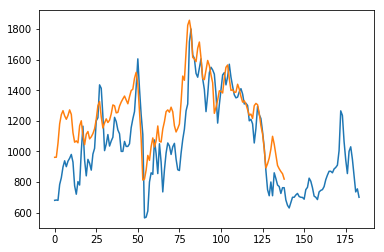

In [99]:
plt.plot(df['paraxylene_RT_USD'])
plt.plot(df['pet'])

In [49]:
# to_train = df[df['date'] < test['date'].min()].drop('date',axis=1)
to_train = df.dropna().drop('date',axis=1)

In [50]:
to_train.head()

,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
1,682.0,736.25,650.000,847.5,35.446667,962.00
2,680.0,738.75,643.750,872.5,37.667273,1053.75
3,783.5,840.00,656.875,955.0,41.762500,1180.00
4,827.5,898.75,774.375,1195.0,42.855909,1240.00
5,897.5,952.50,947.500,1150.0,49.376190,1266.25


In [51]:
to_train.tail()

,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close,pet
134,780.0,934.75,981.250,924.5,56.749091,908.125
135,770.0,840.00,845.625,788.0,48.068421,886.250
136,725.0,786.00,754.375,692.5,48.578000,868.500
137,762.5,816.25,710.625,682.5,49.292727,853.750
138,762.5,802.00,736.250,626.0,45.857000,818.750


In [55]:
to_predict = df[df['date'] >= test['date'].min()].iloc[:, 1:-1]

In [56]:
to_predict.tail()

,paraxylene_RT_USD,paraxylene_SEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD,brent_close
179,950.0,1037.5,620.625,604.0,71.628571
180,840.0,923.5,590.000,584.0,70.134286
181,735.0,853.0,565.625,532.5,63.164737
182,755.0,835.5,518.125,543.5,63.164737
183,700.0,796.5,477.500,517.5,63.164737


In [57]:
model = LinearRegression()

In [58]:
model.fit(to_train.drop('pet', axis=1), to_train['pet'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
pred = model.predict(to_predict)

<h3> Ridge Regression

In [91]:
from sklearn.linear_model import Ridge

In [92]:
ridgereg = Ridge(alpha=5, normalize=True)

In [93]:
ridgereg.fit(to_train.drop('pet', axis=1), to_train['pet'])

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
   random_state=None, solver='auto', tol=0.001)

In [94]:
y_pred = ridgereg.predict(to_predict)

In [95]:
submit = pd.DataFrame()
submit['date'] = test['date'].values
submit['pet'] = y_pred
submit = submit.set_index('date')

In [96]:
submit=submit.iloc[:-1,:]

In [97]:
submit.to_csv('sibur_new_prediction_ridge_alpha_5.csv')

<h5> to csv

In [60]:
submit = pd.DataFrame()
submit['date'] = test['date'].values
submit['pet'] = pred
submit = submit.set_index('date')

In [61]:
submit.shape

(44, 1)

In [63]:
submit.head()

,pet
date,
2016-01-01,825.545794
2016-02-01,868.681969
2016-03-01,918.967828
2016-04-01,897.863616
2016-05-01,904.030463


In [64]:
submit=submit.iloc[:-1,:]

In [65]:
submit.to_csv('sibur_new_prediction.csv')

<h3> check shape with baseline

In [501]:
a = pd.read_csv("pet_linear_baseline.csv")

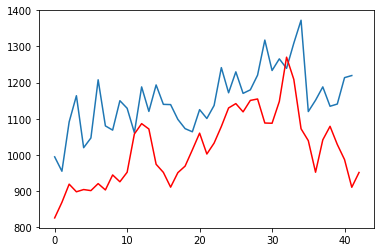

In [502]:
plt.plot(a['pet'])
plt.plot(submit.reset_index()['pet'], color = 'r')
